# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [118]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [119]:
from sklearn.model_selection import train_test_split

# -- YOUR CODE HERE --

X = df.drop(columns=['salary_in_usd'])
y = df['salary_in_usd']

# К лику может привести признак "salary", так как он содержит информацию о таргете

X = X.drop(columns=['salary'])

In [120]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=1/9, random_state=42)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np

categorical_features = ['work_year',
                        'experience_level',
                        'employment_type',
                        'job_title',
                        'salary_currency',
                        'employee_residence',
                        'company_location',
                        'company_size'] # -- YOUR CODE HERE --

# -- YOUR CODE HERE --

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_ohe = encoder.fit_transform(X_train[categorical_features])
X_val_ohe = encoder.transform(X_val[categorical_features])
X_test_ohe = encoder.transform(X_test[categorical_features])

num_features = ['remote_ratio']
X_train_num = X_train[num_features].values
X_val_num = X_val[num_features].values
X_test_num = X_test[num_features].values

X_train_fin = np.hstack([X_train_ohe, X_train_num])
X_val_fin = np.hstack([X_val_ohe, X_val_num])
X_test_fin = np.hstack([X_test_ohe, X_test_num])

lr = LinearRegression()
lr.fit(X_train_fin, y_train)

y_pred = lr.predict(X_test_fin)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f'MAPE: {mape:.4f}%') # -- YOUR CODE HERE -- )
print(f'RMSE: {rmse:.4f}') # -- YOUR CODE HERE -- )

MAPE: 47.6390%
RMSE: 52007.6266


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [122]:
from xgboost.sklearn import XGBRegressor

params = {
    'max_depth': list(range(2, 11)), # -- YOUR CODE HERE -- ,
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # -- YOUR CODE HERE -- ,
    'n_estimators': [100, 200, 300],   # -- YOUR CODE HERE -- ,
    'gamma': [0, 0.1, 0.2],  # -- YOUR CODE HERE --,
    'min_child_weight': list(range(1, 5))
    # -- YOUR CODE HERE --
}

# -- YOUR CODE HERE --

best_mape = float('inf')
best = {}

for md in params['max_depth']:
  for lr in params['learning_rate']:
    for n in params['n_estimators']:
      for g in params['gamma']:
        for mcw in params['min_child_weight']:
          xgbr = XGBRegressor(max_depth=md,
                              learning_rate=lr,
                              n_estimators=n,
                              gamma = g,
                              min_child_weight=mcw)
          xgbr.fit(X_train_fin, y_train)
          y_pred = xgbr.predict(X_val_fin)
          mape = mean_absolute_percentage_error(y_val, y_pred)
          if mape < best_mape:
            best_mape = mape
            best = {'max_depth': md, 'learning_rate': lr, 'n_estimators': n, 'gamma': g, "min_child_weight": mcw}

print('Лучшие параметры:')
for k, v in best.items():
  print(f'{k}: {v}')

Лучшие параметры:
max_depth: 10
learning_rate: 0.3
n_estimators: 200
gamma: 0
min_child_weight: 1


In [127]:
# -- YOUR CODE HERE --

import time

xgb = XGBRegressor(
    max_depth=10,
    learning_rate=0.3,
    n_estimators=200,
    gamma=0,
    min_child_weight = 1,
    random_state=42)

start_tr = time.time()
xgb.fit(X_train_fin, y_train)
end_tr = time.time() - start_tr

start_pr = time.time()
y_pred = xgb.predict(X_test_fin)
end_pr = time.time() - start_pr

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAPE: {mape:.4f}%') # -- YOUR CODE HERE -- )
print(f'RMSE: {rmse:.4f}') # -- YOUR CODE HERE -- )
print(f'Время обучения: {end_tr:.4f}')
print(f'Время предсказания: {end_pr:.4f}')

MAPE: 38.1552%
RMSE: 50358.1236
Время обучения: 0.3551
Время предсказания: 0.0049


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [130]:
from catboost import CatBoostRegressor

params = {
    'depth': list(range(2, 11)), # -- YOUR CODE HERE -- ,
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # -- YOUR CODE HERE -- ,
    'iterations': [100, 200, 300], # -- YOUR CODE HERE -- ,
    'l2_leaf_reg': list(range(1, 6))
    # -- YOUR CODE HERE --
}

# -- YOUR CODE HERE --

best_mape = float('inf')
best = {}

for d in params['depth']:
  for lr in params['learning_rate']:
    for i in params['iterations']:
      for l in params['l2_leaf_reg']:
        cbr = CatBoostRegressor(depth=d,
                                learning_rate=lr,
                                iterations=i,
                                l2_leaf_reg=l,
                                verbose=False)
        cbr.fit(X_train_fin, y_train)
        y_pred = cbr.predict(X_val_fin)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        if mape < best_mape:
          best_mape = mape
          best = {'depth': d, 'learning_rate': lr, 'iterations': i, "l2_leaf_reg": l}

print('Лучшие параметры:')
for k, v in best.items():
  print(f'{k}: {v}')

Лучшие параметры:
depth: 7
learning_rate: 0.2
iterations: 300
l2_leaf_reg: 4


In [131]:
# -- YOUR CODE HERE --

cbr = CatBoostRegressor(
    depth = 7,
    learning_rate = 0.2,
    iterations= 300,
    l2_leaf_reg = 4,
    verbose=False,
    random_state=42)

start_tr = time.time()
cbr.fit(X_train_fin, y_train)
end_tr = time.time() - start_tr

start_pr = time.time()
y_pred = cbr.predict(X_test_fin)
end_pr = time.time() - start_pr

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAPE: {mape:.4f}%') # -- YOUR CODE HERE -- )
print(f'RMSE: {rmse:.4f}') # -- YOUR CODE HERE -- )
print(f'Время обучения: {end_tr:.4f}')
print(f'Время предсказания: {end_pr:.4f}')

MAPE: 39.9198%
RMSE: 49585.5700
Время обучения: 1.9014
Время предсказания: 0.0759


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [132]:
from catboost import Pool

# -- YOUR CODE HERE --

cat_features = ['work_year',
                'experience_level',
                'employment_type',
                'job_title',
                'salary_currency',
                'employee_residence',
                'company_location',
                'company_size']

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

params = {
    'depth': range(1, 11),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': list(range(1, 6))
}

best_mape = float('inf')
best = {}

for d in params['depth']:
  for lr in params['learning_rate']:
    for i in params['iterations']:
      for l in params['l2_leaf_reg']:
        cbr = CatBoostRegressor(depth = d,
                                learning_rate = lr,
                                iterations= i,
                                l2_leaf_reg=l,
                                verbose=False,
                                random_state=42)
        cbr.fit(train_pool)
        y_pred = cbr.predict(val_pool)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        if mape < best_mape:
          best_mape = mape
          best = {'depth': d, 'learning_rate': lr, 'iterations': i, "l2_leaf_reg": l}

print('Лучшие параметры:')

for k, v in best.items():
  print(f'{k}: {v}')

Лучшие параметры:
depth: 4
learning_rate: 0.2
iterations: 100
l2_leaf_reg: 5


In [137]:
cbr = CatBoostRegressor(
    depth = 4,
    learning_rate = 0.2,
    iterations= 100,
    l2_leaf_reg = 5,
    verbose=False,
    random_state=42)

test_pool = Pool(X_test, y_test, cat_features=cat_features)

start_tr = time.time()
cbr.fit(train_pool)
end_tr = time.time() - start_tr

start_pr = time.time()
y_pred = cbr.predict(test_pool)
end_pr = time.time() - start_pr

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAPE: {mape:.4f}%') # -- YOUR CODE HERE -- )
print(f'RMSE: {rmse:.4f}') # -- YOUR CODE HERE -- )
print(f'Время обучения: {end_tr:.4f}')
print(f'Время предсказания: {end_pr:.4f}')

MAPE: 43.6413%
RMSE: 51175.1297
Время обучения: 0.1859
Время предсказания: 0.0008


**Ответ:** качество модели ухудшилось, но время обучения и предсказания уменьшилось

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [136]:
from lightgbm import LGBMRegressor


params = {
    'max_depth': list(range(2, 11)), # -- YOUR CODE HERE -- ,
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # -- YOUR CODE HERE -- ,
    'n_estimators': [100, 200, 300],
    'num_leaves': [10, 15, 30, 60, 100]# -- YOUR CODE HERE -- ,
    # -- YOUR CODE HERE --
}

# -- YOUR CODE HERE --

best_mape = float('inf')
best = {}

for md in params['max_depth']:
  for lr in params['learning_rate']:
    for n in params['n_estimators']:
      for l in params['num_leaves']:
        lgmbr = LGBMRegressor(max_depth=md,
                              learning_rate=lr,
                              n_estimators=n,
                              num_leaves=l,
                              verbosity=-1,
                              random_state=42)
        lgmbr.fit(X_train_fin, y_train)
        y_pred = lgmbr.predict(X_val_fin)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        if mape < best_mape:
          best_mape = mape
          best = {'max_depth': md, 'learning_rate': lr, 'n_estimators': n, 'num_leaves': l}

print('Лучшие параметры:')
for k, v in best.items():
  print(f'{k}: {v}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Лучшие параметры:
max_depth: 6
learning_rate: 0.3
n_estimators: 200
num_leaves: 10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [138]:
# -- YOUR CODE HERE --

lgbmr = LGBMRegressor(
    max_depth = 6,
    learning_rate = 0.3,
    n_estimators=200,
    num_leaves=10,
    verbosity=-1,
    random_state=42)

start_tr = time.time()
lgbmr.fit(X_train_fin, y_train)
end_tr = time.time() - start_tr

start_pr = time.time()
y_pred = lgbmr.predict(X_test_fin)
end_pr = time.time() - start_pr

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAPE: {mape:.4f}%') # -- YOUR CODE HERE -- )
print(f'RMSE: {rmse:.4f}') # -- YOUR CODE HERE -- )
print(f'Время обучения: {end_tr:.4f}')
print(f'Время предсказания: {end_pr:.4f}')

MAPE: 43.6175%
RMSE: 51179.3942
Время обучения: 0.0654
Время предсказания: 0.0045


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [139]:
result = pd.DataFrame({
    'Модель': ['XGBoost', 'CatBoost', 'LightGBM'],
    'Лучшие параметры': [
        '{"max_depth": 10, "learning_rate": 0.3, "n_estimators": 200, "gamma": 0, "min_child_weight": 1}',
        '{"depth": 7, "learning_rate": 0.2, "iterations": 300, "l2_leaf_reg": 4}',
        '{"max_depth": 6, "learning_rate": 0.3, "n_estimators": 200, "num_leaves": 10}'],
    'MAPE': [38.1552, 39.9198, 43.6175],
    'RMSE': [50358.1236, 49585.5700, 51179.3942],
    'Время обучения': [0.3551, 1.9014, 0.0654],
    'Время предсказания': [0.0049, 0.0759, 0.0045]})

result

,Модель,Лучшие параметры,MAPE,RMSE,Время обучения,Время предсказания
0,XGBoost,"{""max_depth"": 10, ""learning_rate"": 0.3, ""n_est...",38.1552,50358.1236,0.3551,0.0049
1,CatBoost,"{""depth"": 7, ""learning_rate"": 0.2, ""iterations...",39.9198,49585.5700,1.9014,0.0759
2,LightGBM,"{""max_depth"": 6, ""learning_rate"": 0.3, ""n_esti...",43.6175,51179.3942,0.0654,0.0045


**Ответ:**

Качество:
- CatBoost показал наименьшую ошибку RMSE
- XGBoost имеет лучший показатель MAPE
- LightGBM показал наихудшие показатели по всем меркам

Скорость:
- LightGBM имеет лучшие показатели скорости обучения и предсказания, модель обучается и предсказывает быстро
- CatBoost имеет худшие показатели скорости обучения и предсказания, модель обучается и предсказывает наименее медленно

Гиперпараметры:
- XGBoost самая глубокая модель, learning_rate высокий
- CatBoost имеет регуляризацию, умеренная глубина, большое количество итераций (из-за этого требует много времени)
- LightGBM имеет высокий learning_rate, наименьшая глубина, работает быстрее, но качество снижается

**ВЫВОД:**
- CatBoost - медленная модель, но с высоким качеством
- LightGBM - самая быстрая модель, но с низким качеством
- XGBoost является неким компромиссом между быстротой и качеством модели

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [140]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [141]:
# -- YOUR CODE HERE --
ratings = ratings.T
ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [142]:
# -- YOUR CODE HERE --
ratings = ratings.drop(index=['user'])
ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [143]:
# -- YOUR CODE HERE --
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
santogold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [144]:
from sklearn.cluster import KMeans

# -- YOUR CODE HERE --

km = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = km.fit_predict(ratings)

ratings1 = ratings.copy()
ratings1['clusters'] = clusters

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [145]:
# -- YOUR CODE HERE --

ratings1['clusters'].value_counts()

,count
clusters,
3,882
0,115
4,1
2,1
1,1


**Ответ:** Кластеризация не получилась полезной, так как кластеры несбалансированны: в 3 кластер входят большинство артистов, в то время как в 1, 2, 4 по одному артисту. KMeans может выдать такой результат, если большинство артистов слушают похожим образом, если в данных соедражтся много пропусков (то есть 0), в данных есть выбросы

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [146]:
# -- YOUR CODE HERE --
cluster1 = ratings1['clusters'].value_counts()[ratings1['clusters'].value_counts() == 1].index
artist = ratings1[ratings1['clusters'].isin(cluster1)]
artist

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,clusters
the beatles,0.0,0.0,0.0,0.0,0.043529,0.0,0.0,0.0,0.093398,0.017621,...,0.0,0.121169,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.0,4
niИ,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.012281,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,2
日dir en grey,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [154]:
# -- YOUR CODE HERE --
total = (ratings1.drop(columns='clusters') > 0).shape[1]

user_art = (ratings1.drop(columns='clusters') > 0).sum(axis=1)
user_share = user_art / total

mean_art = ratings1.drop(columns='clusters').replace(0, np.nan).mean(axis=1)

artist = pd.DataFrame({
    'user_share': user_share,
    'mean_art': mean_art
})

print(f"Доля пользователей для The Beatles: {artist.loc['the beatles']['user_share']}")
print(f"Cредняя доля прослушивания для The Beatles: {artist.loc['the beatles']['mean_art']}")
print(f"\nМаксимальная доля пользователей: {artist['user_share'].max()}")
print(f"Максимальная средняя доля прослушивания: {artist['mean_art'].max()}")
print(f"Среднее значение средней доли прослушивания: {artist['mean_art'].mean()}")

Доля пользователей для The Beatles: 0.3342
Cредняя доля прослушивания для The Beatles: 0.05496402331553399

Максимальная доля пользователей: 0.3342
Максимальная средняя доля прослушивания: 0.16558195751344534
Среднее значение средней доли прослушивания: 0.03837181821582776


**Ответ:** Можем заметить, что у The Beatles наивысший показатель доли слушающих пользователей. Полее трети пользователей (33%) слушают The Beatles. Средняя доля прослушивания у The Beatles не является самым высоким показателем, однако больше среднего по датасету, что также говорит о высокой популярности данной группы. The Beatles выделяется в отдельный кластер, потому что группа отличается от остальных исполнителей высокой популярностью и регулярностью прослушивания

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [155]:
from sklearn.preprocessing import normalize

# -- YOUR CODE HERE --

ratings_norm = normalize(ratings, norm='l2')

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [156]:
# -- YOUR CODE HERE --

km = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = km.fit_predict(ratings_norm)

ratings_norm = pd.DataFrame(ratings_norm, index=ratings.index, columns=ratings.columns)
ratings_norm['clusters'] = clusters
ratings_norm['clusters'].value_counts()

,count
clusters,
4,486
1,162
3,140
2,133
0,79


**Ответ** Можем заметить, что после нормализации стало намного лучше. Кластеры стали менее несбалансированными: теперь кластеры содержат значимое количество исполнителей (кластеров с 1 исполнителем теперь нет). Кластеризация теперь может быть полезной, так как появились более "осмысленные" кластеры, которые содержат достаточное количество исполнителей

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [157]:
from scipy.spatial.distance import cosine


centroids = km.cluster_centers_

# -- YOUR CODE HERE --

top = {}

for i in range(5):
  art = ratings_norm[ratings_norm['clusters'] == i].drop(columns='clusters')

  dist = art.apply(lambda row: cosine(row, centroids[i]), axis=1)

  top[i] = dist.sort_values().head(10).index.tolist()

for k, v in top.items():
  print(f'\n Кластер {k}:')
  for i in v:
    print(i)


 Кластер 0:
nas
jay-z
kanye west
lupe the gorilla
a tribe called quest
the roots featuring d'angelo
gangstarr
little brother
lil' wayne
murs and 9th wonder

 Кластер 1:
fall out boy
the all-americian rejects
paramore
kelly clarkson
john mayer
the fray
maroon5
dashboard confesssional
somethings corporate
coldplay

 Кластер 2:
brand new
blink-182
alkaline trio
against me!
underoath
descendents
new found glory
less than jake
thrice
chiodos

 Кластер 3:
the beatles
the rolling stones
dylan. bob
who
led zeppelin.
miles davis.
simon and garfunkel
young, neil
pink fluid
velvet underground

 Кластер 4:
radiohead
the arcade fire
the shins
sufjan stevens
belle and sebastian
broken social scene
the pixies
animal collective
modest mouse
spoon


**Ответ:**
Кластеры поделились по жанру, в которых работают артисты. Вероятно, пользователи имеют схожие способы прослушивания исполнителей определенных жанров.

Кластер 0: содержит иполнителей в стиле **хип-хоп** и **рэп**

Кластер 1: содержит иполнителей в стиле **поп-рок**

Кластер 2: содержит иполнителей в стиле **панк-рок**

Кластер 3: содержит иполнителей в стиле **классический рок**

Кластер 4: содержит иполнителей в стиле **инди и альтернативный рок**

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

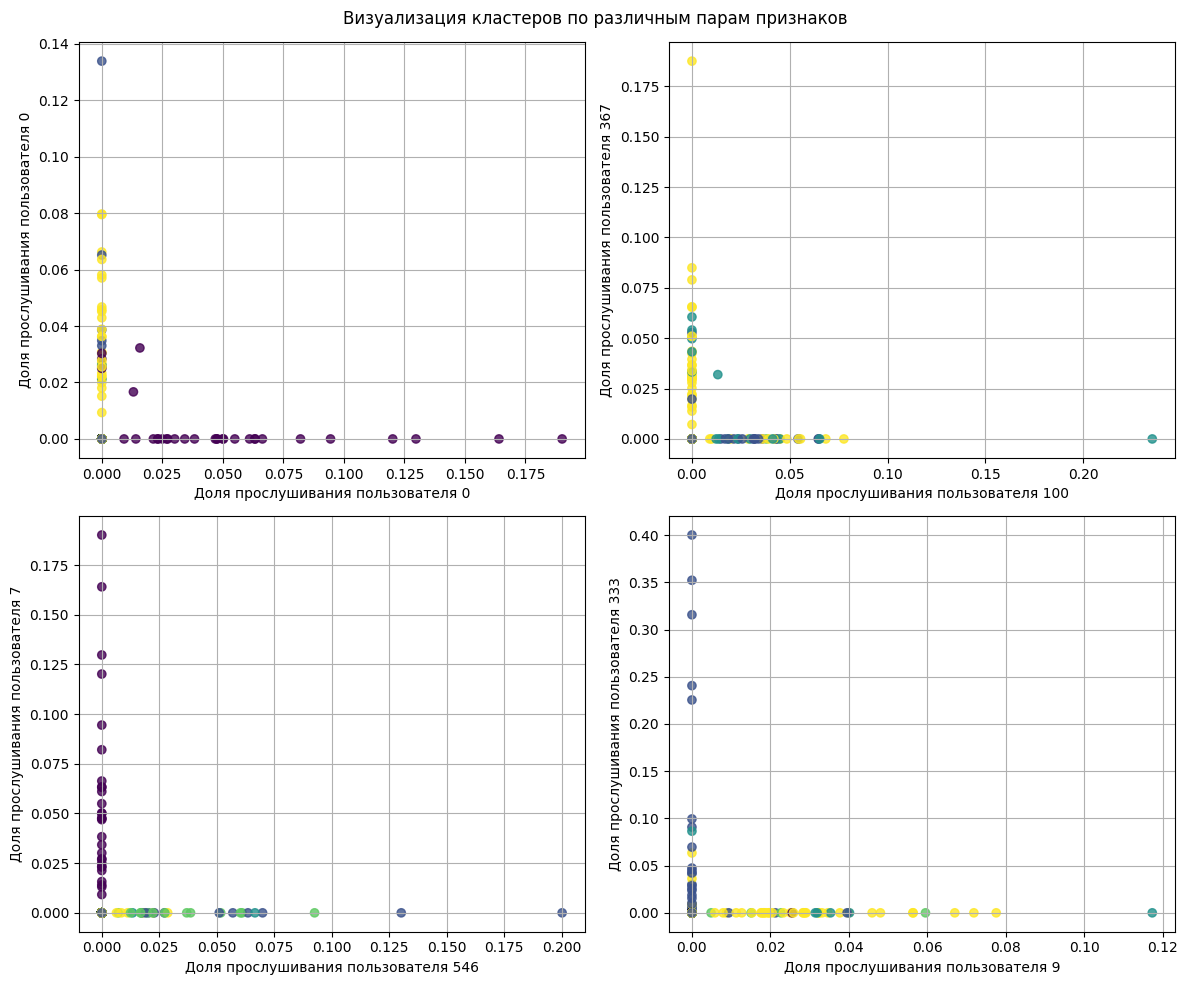

In [168]:
import matplotlib.pyplot as plt


# -- YOUR CODE HERE --

colors = ratings_norm['clusters']

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.suptitle('Визуализация кластеров по различным парам признаков')
ax[0, 0].scatter(ratings_norm.iloc[:, 7], ratings_norm.iloc[:, 0], c=colors, alpha=0.8)
ax[0, 0].set_xlabel(f'Доля прослушивания пользователя {0}')
ax[0, 0].set_ylabel(f'Доля прослушивания пользователя {0}')
ax[0, 0].grid(True)

ax[0, 1].scatter(ratings_norm.iloc[:, 100], ratings_norm.iloc[:, 367], c=colors, alpha=0.8)
ax[0, 1].set_xlabel(f'Доля прослушивания пользователя {100}')
ax[0, 1].set_ylabel(f'Доля прослушивания пользователя {367}')
ax[0, 1].grid(True)

ax[1, 0].scatter(ratings_norm.iloc[:, 546], ratings_norm.iloc[:, 7], c=colors, alpha=0.8)
ax[1, 0].set_xlabel(f"Доля прослушивания пользователя {546}")
ax[1, 0].set_ylabel(f"Доля прослушивания пользователя {7}")
ax[1, 0].grid(True)

ax[1, 1].scatter(ratings_norm.iloc[:, 9], ratings_norm.iloc[:, 333], c=colors, alpha=0.8)
ax[1, 1].set_xlabel(f"Доля прослушивания пользователя {9}")
ax[1, 1].set_ylabel(f"Доля прослушивания пользователя {333}")
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()

**Ответ:** Графики получились нерепрезентативными, потому что все кластеры собраны в одном месте, разделение по кластерам почти не отражается. Такое может быть из-за того, что в датасете высокая размерность данных, а мы используем только 2 признака, из-за чего теряется часть информации.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


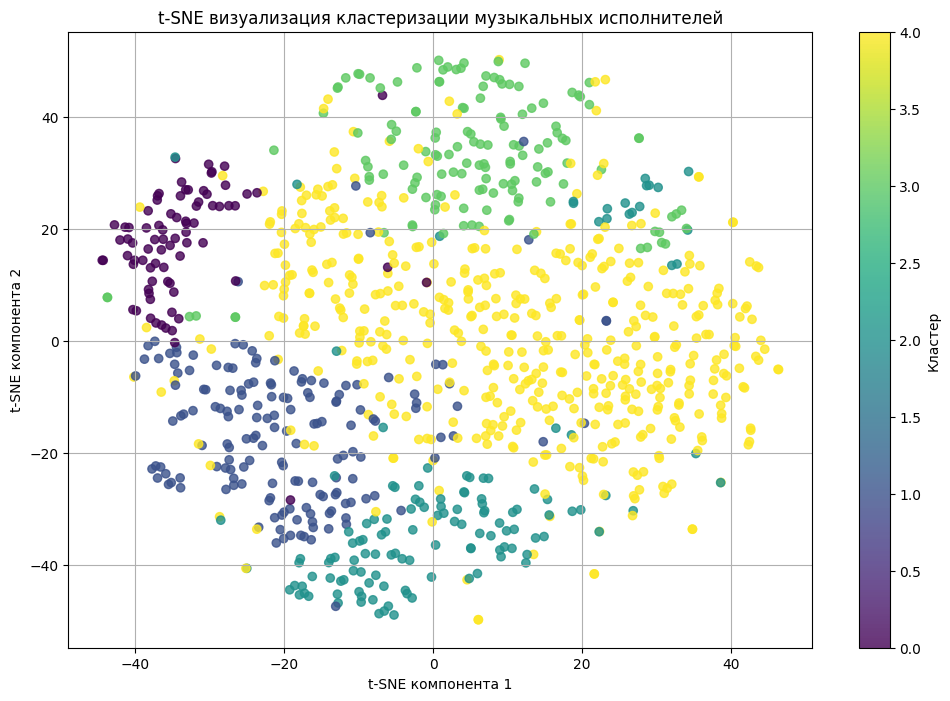

In [169]:
from sklearn.manifold import TSNE

# -- YOUR CODE HERE --

data = ratings_norm.drop(columns=['clusters'])
clusters = ratings_norm['clusters']

tsne = TSNE(n_components=2,
            perplexity=30,
            random_state=42,
            n_iter=1000)
data_tsne = tsne.fit_transform(data)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_tsne[:, 0],
                      data_tsne[:, 1],
                      c=clusters,
                      alpha=0.8)

plt.colorbar(scatter, label='Кластер')
plt.title('t-SNE визуализация кластеризации музыкальных исполнителей')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.grid(True)

plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [160]:
from sklearn.metrics import silhouette_score

# -- YOUR CODE HERE --

df = ratings_norm.drop(columns=['clusters'])

best_score = -1
best_n = 0
nclusters = range(2, 101)

for c in nclusters:
  km = KMeans(n_clusters=c, random_state=42, n_init=10)
  clusters = km.fit_predict(df)
  score = silhouette_score(df, clusters)

  if score > best_score:
    best_score = score
    best_n = c

print(f'Оптимальное количество кластеров: {best_n}')

Оптимальное количество кластеров: 84


In [170]:
km = KMeans(n_clusters=84, random_state=42, n_init=10)
clusters = km.fit_predict(df)

ratings_norm['clusters1'] = clusters

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
# -- YOUR CODE HERE --

centroids = km.cluster_centers_

top = {}

for i in range(8):
  art = ratings_norm[ratings_norm['clusters1'] == i].drop(columns=['clusters', 'clusters1'])

  dist = art.apply(lambda row: cosine(row, centroids[i]), axis=1)

  top[i] = dist.sort_values().head(10).index.tolist()

for k, v in top.items():
  print(f'\n Кластер {k}:')
  for i in v:
    print(i)


 Кластер 0:
raekwon
wu-tang clan
gza/genius
ghostface killah
mobb deep
cypress hill

 Кластер 1:
she wants revenge
shiny toy guns

 Кластер 2:
vampire weekend
mgmt
girl talk
the go! team
the blow
dr. dog
bishop allen

 Кластер 3:
the flaming lips
the apples in stereo
elvis costello and the attractions
grandaddy
the notwist
sparklehorse
orbital

 Кластер 4:
the smashing pumpkins
vnv nation
the blood brothers
moby
the pillows

 Кластер 5:
all time low
mayday parade
forever the sickest kids
fall out boy
cute is what we aim for
the academy is...
cobra starship
paramore
the spill canvas
boys like girls

 Кластер 6:
kanye west
jay-z
lupe the gorilla
lil' wayne
t.i.
ludacris
t-pain
drake
chris brown
ross, rick

 Кластер 7:
iron maiden
megadeth
judas priest
black sabbath
slayer
metallica
ozzy osbourne
pantera
queensrÿche
acdc


**Ответ:** Если раньше кластеры выделялись по жанру, то теперь кластеры стали более специализированными: теперь они отражают конкретные поджанры, стили, временные эпохи. Смысл кластеров остался прежним, но теперь они более детализированные.

Кластер 5: исполнители в жанре **эмо-поп-панк 2000-х**

Кластер 7: исполнители в жанре **хэви-треш-метал**






Сделайте t-SNE визуализацию полученной кластеризации.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


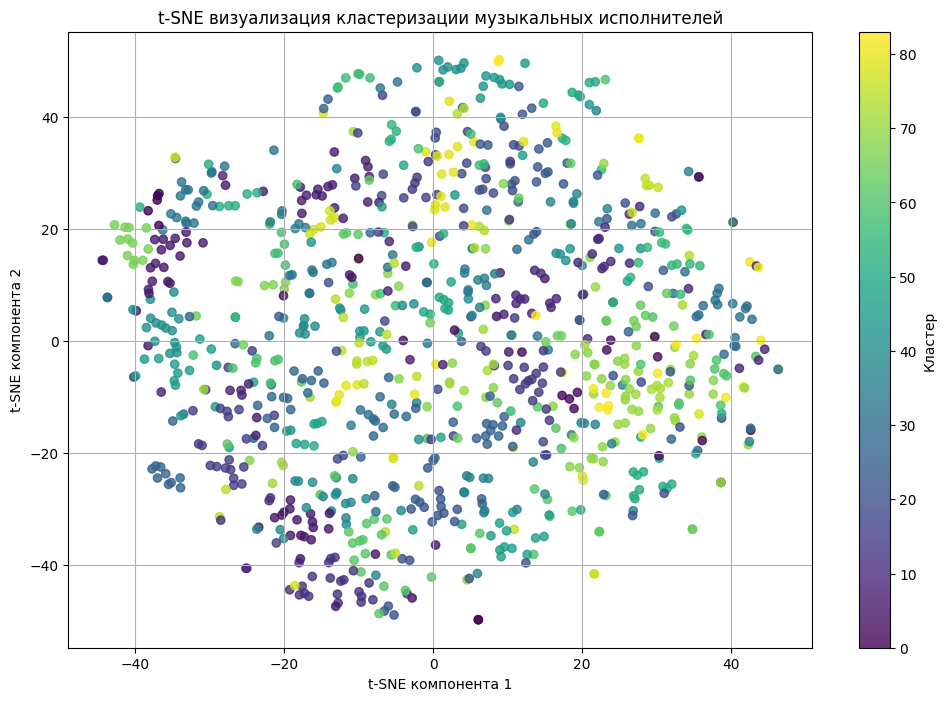

In [171]:
# -- YOUR CODE HERE --

from sklearn.manifold import TSNE

# -- YOUR CODE HERE --

data = ratings_norm.drop(columns=['clusters', 'clusters1'])
clusters = ratings_norm['clusters1']

tsne = TSNE(n_components=2,
            perplexity=30,
            random_state=42,
            n_iter=1000)
data_tsne = tsne.fit_transform(data)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_tsne[:, 0],
                      data_tsne[:, 1],
                      c=clusters,
                      alpha=0.8)

plt.colorbar(scatter, label='Кластер')
plt.title('t-SNE визуализация кластеризации музыкальных исполнителей')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.grid(True)

plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

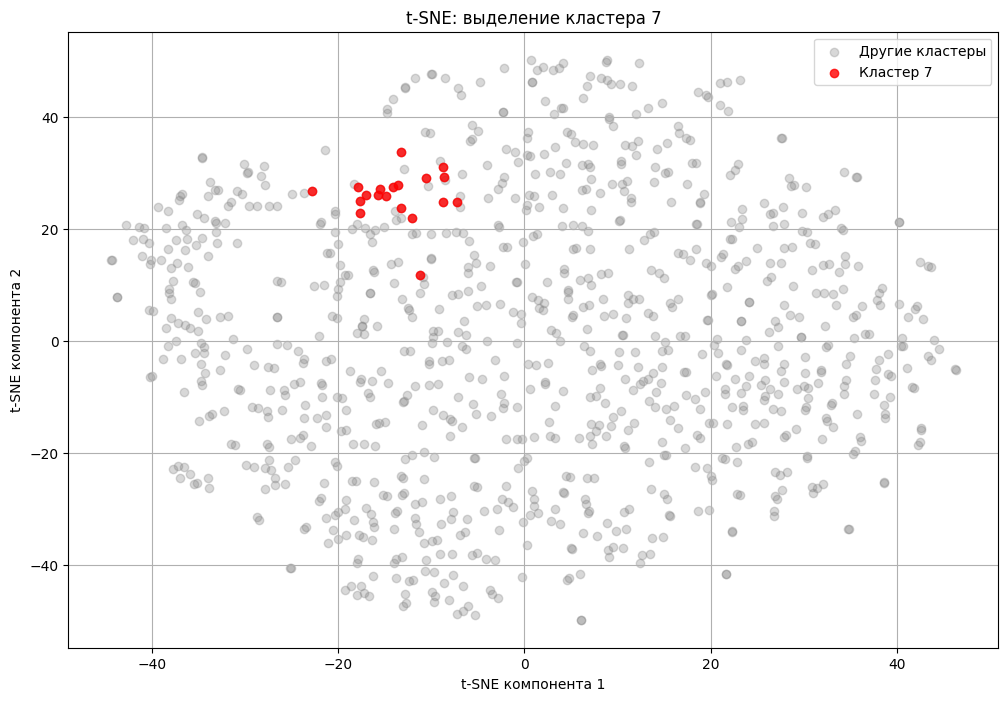

In [172]:
# -- YOUR CODE HERE --

cluster_id = 7
c = (clusters == cluster_id)

plt.figure(figsize=(12, 8))

plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c='grey', alpha=0.3, label='Другие кластеры')

plt.scatter(data_tsne[c, 0], data_tsne[c, 1], c='red', alpha=0.8, label=f'Кластер {cluster_id}')

plt.title(f't-SNE: выделение кластера {cluster_id}')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.legend()
plt.grid(True)

plt.show()

**Ответ:** Кластер хорошо отражается в визуализации: представители этого класса находятся рядом в одной области